<center>

# DCGAN sous Pytorch

</center>

DCGAN (Deep Convolutional GAN) est une variante spécifique de GAN (Generative Adversarial Network) qui a été conçue pour générer des images réalistes. Le GAN est un type d'architecture de réseau de neurones artificiels utilisé dans l'apprentissage non supervisé. Il est composé d'un générateur et d'un discriminateur qui sont entraînés simultanément: le générateur crée de nouvelles données et le discriminateur évalue à quoi point ces données sont réalistes. DCGAN améliore la génération d'images, en utilisant des couches de convolution profondes dans le discriminateur et le générateur.

# Importation des bibliothèques

In [59]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
import os
from IPython.display import Image
from torchvision.utils import save_image
from PIL import Image

# Génération de chiffres manuscrits

## Importation des données

Nous commençons par importer les données réelles à partir d'un data set MNIST de torchvision.datasets.

In [60]:
#Création d'un MNIST dataset (collection d'images de taille 28x28 pixels en teintes
#de gris représentant des chiffres écris à la main accompagnés de leur étiquette
#indiquant de quel chiffre il s'agit.)
mnist = MNIST(root='data',
              train=True,
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [61]:
img, label = mnist[0]
print(torch.min(img), torch.max(img))

tensor(-1.) tensor(1.)


On voit que les pixels prennent des valeurs dans l'intervalle [-1,1]. On écrit donc une fonction de dénormalisation qui envoie l'intervalle [-1,1] sur l'intervalle [0,1]: 

In [20]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

img_norm = denorm(img)

Label: 5


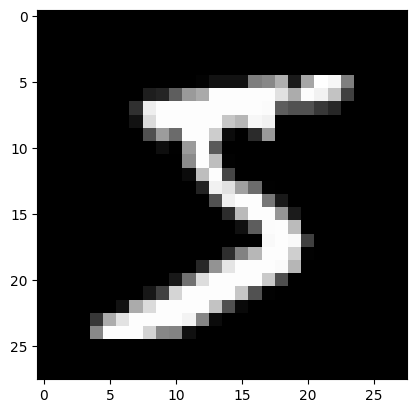

In [21]:
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)


Créons un dataloader pour charger les images par lots.

In [81]:
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True) 
#L'option shuffle=True indique que les données seront mélangées à chaque époque (utile pour l'entraînement)

First batch
torch.Size([100, 1, 28, 28])


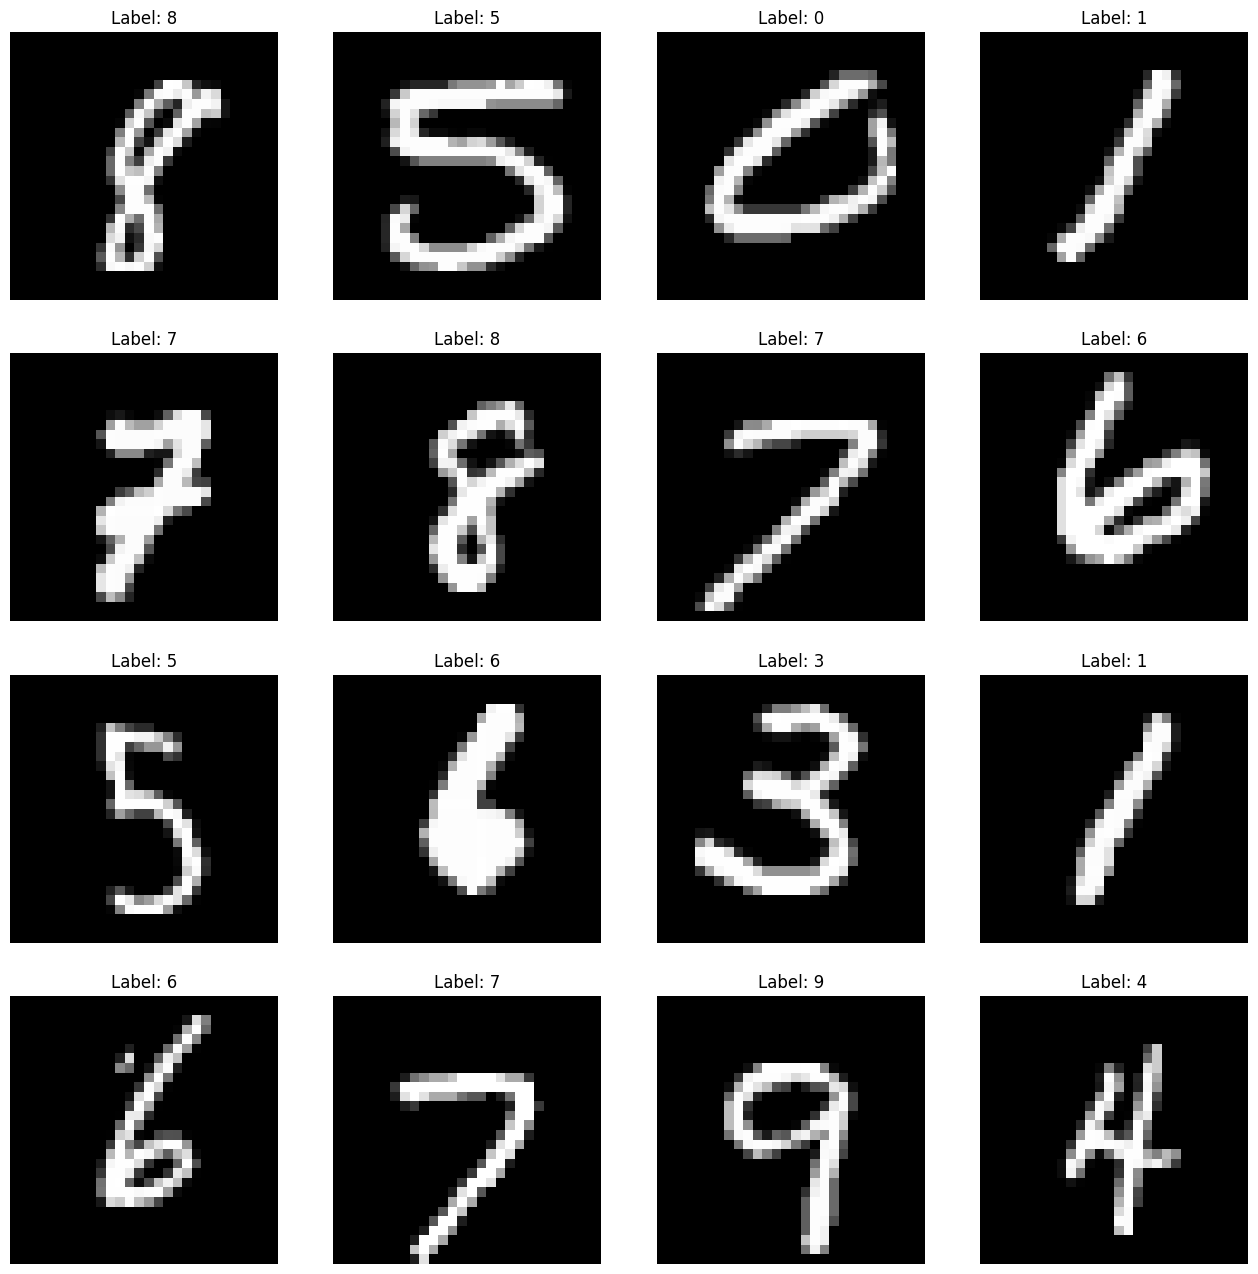

In [23]:
for img_batch, label_batch in data_loader:
    print('First batch')
    print(img_batch.shape)

    # Afficher les 16 premières images du premier mini-batch
    plt.figure(figsize=(16, 16))
    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(img_batch[i][0], cmap='gray')
        plt.title(f'Label: {label_batch[i]}')
        plt.axis('off')

    plt.show()
    break

images = images.reshape(images.size(0), 1, 28, 28) 




A présent, on créé   'device'    qui peut être utilisé pour déplacer les données et les modèles vers un GPU, s'il est disponible. 
Un GPU (Graphics Processing Unit) est une unité de traitement graphique, également appelée carte graphique. C'est un composant extrêmement puissant pour effectuer des calculs parallèles d'où son utilisation dans des domaines tels que le (deep learning).

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Discriminateur

Le discriminateur prend une image en entrée et tente de la classer comme "réelle" ou "générée". Bien que nous puissions utiliser un CNN (Convutional Neural Network, c'est-à-dire un réseau neuronal spécialement conçu pour les images par exemple) pour le discriminateur, nous utiliserons ici un réseau feedforward simple avec 3 couches linéaires (simplification). 

La sortie du discriminateur est un flotant dans l'intervalle [0,1]. Elle représente la probabilité que l'image d'entrée soit "fausse", (c'est-à-dire générée)

In [25]:
image_size = 784  # l'entrée une image de taille 28x28 (=784) vue comme un vecteur de taille 784
hidden_size = 256 #taille de la couche cachée, c'est-à-dire de la couche entre les deux première couche linéaire.

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device);  #On déplace le discriminateur dans device

## Générateur

L'entrée du générateur est généralement un vecteur ou une matrice utilisée comme point de départ pour générer une image. Nous utilisons un réseau neuronal avec 3 couches, et la sortie sera un vecteur de taille 784, qui peut être transformé en une image de 28x28 pixels.

In [82]:
latent_size = 64  # dimension  de l'espace dans lequel le générateur opère pour créer de nouvelles données. 
# Dans un modèle génératif comme un GAN, un vecteur latent est souvent utilisé comme entrée pour le générateur.

G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())  ##La fonction tangente hyperbolique est utilisée comme fonction de normalisation 

G.to(device); #On déplace le générateur dans device


# Entraînements

### Entraînement du Discriminateur

Nous utilisons la fonction de perte Binary Cross Entropy pour quantifier à quel point le discriminateur est capable de différencier entre les images réelles et les images générées.

\begin{equation}
\text{Binary Cross Entropy} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]
\end{equation}


In [27]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [83]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Création des étiquettes qui seront utilisées pour la BCE (Binary Cross Entropy)
    real_labels = torch.ones(batch_size, 1).to(device) # 0 pour les vraies images
    fake_labels = torch.zeros(batch_size, 1).to(device) # 1 pour les images générées
        
    # Calcul de la perte pour les images réelles à l'aide de la BCE entre les sorties du discriminateur (outputs) et les étiquettes réelles (real_labels)
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Calcul de la perte pour les images générées:
    z = torch.randn(batch_size, latent_size).to(device) #génération de vecteurs de bruit
    fake_images = G(z) # le vecteur de bruit est utlisé comme entrée pour le générateur
    outputs = D(fake_images)  # les images générées par le vecteur de bruit sont introduites dans le discriminateur
    d_loss_fake = criterion(outputs, fake_labels) # Calcul de la perte des sorties du discriminateur pour les images générées (outputs) et les étiquettes générées (fake_labels)
    fake_score = outputs

    
    d_loss = d_loss_real + d_loss_fake  # Perte totale
    reset_grad() # Réinitialisation des gradients
    d_loss.backward()  # Calcul des gradients de la perte totale du discriminateur par rétropropagation
    d_optimizer.step()# Ajustation des  paramètres en utilisant la rétropropagation
    
    return d_loss, real_score, fake_score

### Entraînement du générateur

Nous générons un lot d'images à l'aide du générateur, que nous passons dans le discriminateur. Puisque l'objectif du générateur est de tromper le discriminateur, nous calculons la perte en fixant les étiquettes cibles à 1. Nous effectuons ensuite une descente en gradient sur la perte afin de modifier les paramètres du générateur pour qu'il s'améliore dans la génératon d'images réalistes


In [29]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

### Entraînement du modèle

On crée un dossier dans lequel on enregistre toutes les images intermédiaires afin d'oberserver l'évolution du modèle.

In [30]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):  # vérifie que le dossier n'existe pas déjà
    os.makedirs(sample_dir)

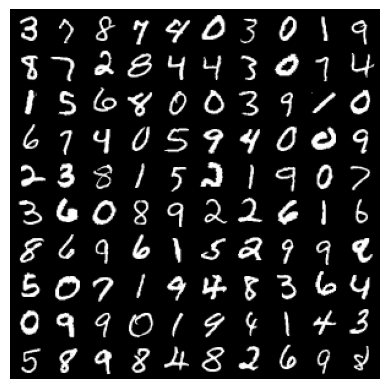

In [32]:
# Pour avoir un point de comparaison, on sauvegarde une vraie image
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)  
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
img_path = os.path.join(sample_dir, 'real_images.png')
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

On crée ensuite une fonction save_fake_images qui , à partir de vecteurs aléatoires génére des images et les sauvegardent dans un répertoire en les numérotant en fonction de l'indice fourni. Cela permet de visualiser l'évolution des images générées au fil de l'entraînement du générateur.

In [33]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)  # Génération d'un ensemble de vecteur bruits

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

Le script suivant est un script d'entraînement GAN (Generative Adversarial Network) pour le jeu de données MNIST. 
Il réalise l'entraînement d'un GAN sur le jeu de données MNIST, en enregistrant les pertes et les scores à chaque étape, et en sauvegardant des échantillons d'images générées à la fin de chaque époque.

In [34]:
num_epochs = 300 # Nombre total d'époques pendant lesquelles le modèle va être entraîné
total_step = len(data_loader) # Nombre total d'itération dans chaque époque
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Les images réelles sont chargées et transformées en vecteurs pour être utilisées comme entrées
        images = images.reshape(batch_size, -1).to(device)  #

        # Entraînement du générateur et du Discriminateur
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Affichage des informations de l'entraînement
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i + 1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    save_fake_images(epoch + 1) # Sauvegarde des images générées

Epoch [0/300], Step [200/600], d_loss: 0.0819, g_loss: 4.1969, D(x): 0.97, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.1548, g_loss: 5.6832, D(x): 0.95, D(G(z)): 0.06
Epoch [0/300], Step [600/600], d_loss: 0.0696, g_loss: 5.3238, D(x): 0.98, D(G(z)): 0.05
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.1128, g_loss: 4.8364, D(x): 0.96, D(G(z)): 0.06
Epoch [1/300], Step [400/600], d_loss: 0.0492, g_loss: 4.6223, D(x): 0.98, D(G(z)): 0.02
Epoch [1/300], Step [600/600], d_loss: 1.0996, g_loss: 3.6471, D(x): 0.81, D(G(z)): 0.40
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.2904, g_loss: 3.4709, D(x): 0.85, D(G(z)): 0.04
Epoch [2/300], Step [400/600], d_loss: 0.2285, g_loss: 3.6869, D(x): 0.94, D(G(z)): 0.12
Epoch [2/300], Step [600/600], d_loss: 0.1700, g_loss: 4.3920, D(x): 0.96, D(G(z)): 0.06
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2427, g_loss: 4.0278, D(x): 0.89, D(G(z)): 0.06
Epoch [3/300], Step [400/6

Affichons quelques images pour se rendre compte de l'avancé du programme

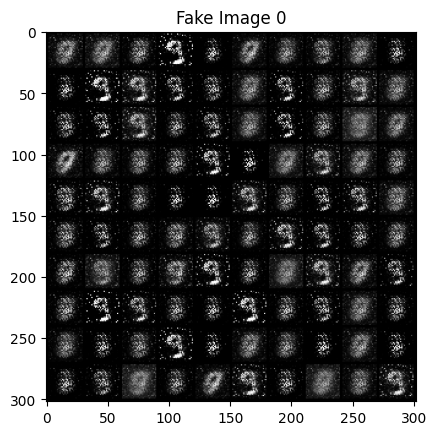

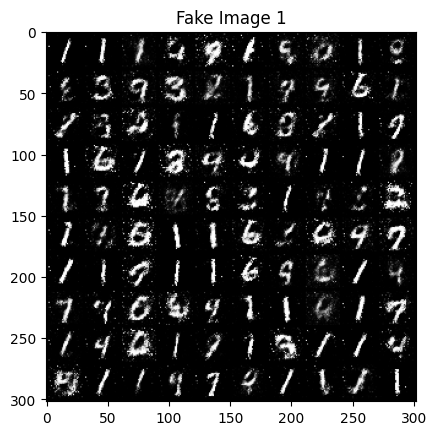

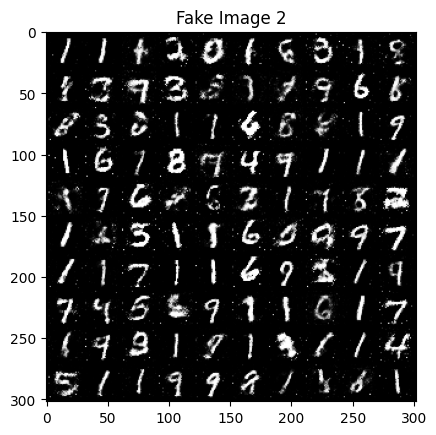

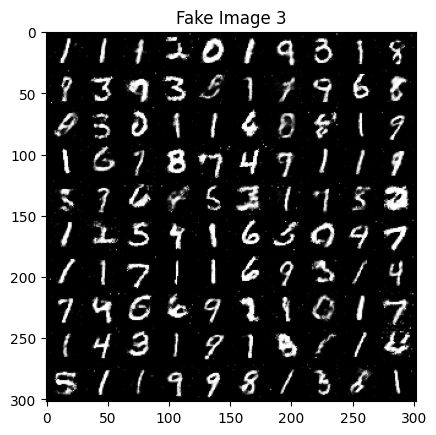

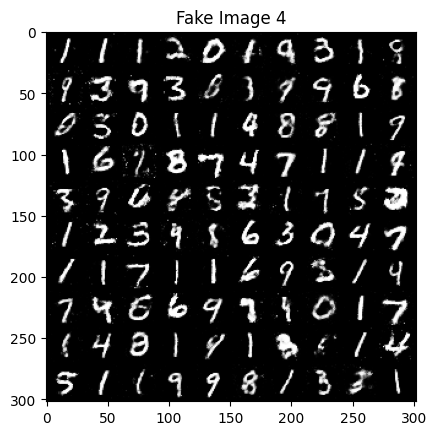

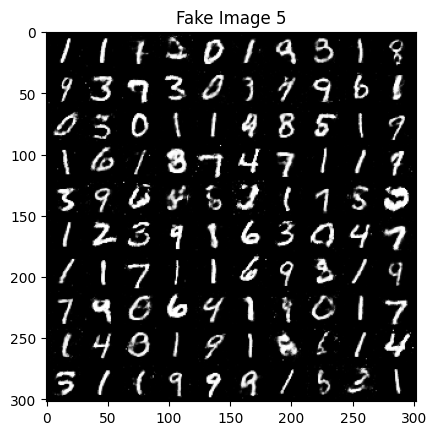

In [37]:
img0_path = './samples/fake_images-0010.png'
img0 = Image.open(img0_path)
plt.imshow(img0)
plt.title('Fake Image 0')
plt.show()


img1_path = './samples/fake_images-0050.png'
img1 = Image.open(img1_path)
plt.imshow(img1)
plt.title('Fake Image 1')
plt.show()


img2_path = './samples/fake_images-0100.png'
img2 = Image.open(img2_path)
plt.imshow(img2)
plt.title('Fake Image 2')
plt.show()

img3_path = './samples/fake_images-0150.png'
img3 = Image.open(img3_path)
plt.imshow(img3)
plt.title('Fake Image 3')
plt.show()

img4_path = './samples/fake_images-0200.png'
img4 = Image.open(img4_path)
plt.imshow(img4)
plt.title('Fake Image 4')
plt.show()

img5_path = './samples/fake_images-0300.png'
img5 = Image.open(img5_path)
plt.imshow(img5)
plt.title('Fake Image 5')
plt.show()



# GENERATION DE VISAGES AVEC PYTORCH

In [62]:
import random
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import torch.multiprocessing as mp

In [63]:
manualSeed = 10 #On choisit un point de départ de manière aléatoire

#Si on veut des résultats différents à chaque utilisation, on peut remplacer la ligne précédente par :
#manualSeed = random.randint(1, 10000)

random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True)

## Importation des données

Les données utilisées sont issues du dataset "Celeb-A Faces" disponible à ce lien : http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

L'ensemble des données sera téléchargé sous le nom de fichier "img_align_celeba.zip" dans un répertoire nommé "celeba".

In [64]:
dataroot = "/Users/lina/Desktop/PYcharm/pythonProject/celeba"

Initialisons maintenant les paramètres qui définissent la manière dont le GAN va être entraîné, y compris la structure des réseaux de génération et de discrimination, la taille des tenseurs d'entrée et de sortie, et les paramètres d'optimisation.

In [65]:
workers = 2 # Nombre de travailleur pour le dataloader

batch_size = 128 # Taille du lot pendant l'entrainement

image_size = 64 # Taille des images pendant l'entra^nement

nc = 3 # On utilise 3 canaux dans pour les images de couleur (RVB)

nz = 100 # Taille du vecteur latent(= taille de l'entrée du générateur

ngf = 64 # Taille des cartes de caractéristiques dans le générateur

ndf = 64 # Taille des cartes de caractéristiques dans le discrimateur 

num_epochs = 5 # Nombre de boucles d'entrainement

lr = 0.0002 # taux d'apprentissage

beta1 = 0.5 #paramètre pour les optimiseurs Adam

ngpu = 1 #Spécification d'un GPU ou non

In [66]:
# Création du dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

# Création du dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

In [67]:
# Selection automatique du meilleur dispositif disponible (GPU s'il est disponible et ngpu>0, sinon CPU) pour effectuer les calculs.
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

Tous les poids du modèle doivent être initialisés de manière aléatoire à partir d'une distribution normale avec une moyenne de 0 et on choisit un écart type de 0,02. On définit alors la fonction `weights_init` qui prend un modèle initialisé en entrée et réinitialise toutes les couches de convolution, convolution-transposition et normalisation par lots pour répondre à ces critères.

In [68]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

## Générateur

Le générateur transforme un vecteur latent  en une image réaliste de taille (nc) x 64 x 64. Son fonctionnement est le même que pour la génération des chiffres en écriture manuscrite vue précédemment.

In [69]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),      # Couche de convolution transposée
            nn.BatchNorm2d(ngf * 8),        # Couche de normalisation par lots
            nn.ReLU(True),      # Fonction d'activation
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            
        )

    def forward(self, input):
        return self.main(input)



In [70]:
# Création du générateur
netG = Generator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))  # Permet l'entraînement en parallèle sur plusieurs GPU


netG.apply(weights_init) # Application de la fonction d'initialisation des poids au générateur.


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## Discriminateur 

On définit une classe d'un discriminateur convolutionnel avec plusieurs couches pour la tâche de discrimination entre images réelles et images générées dans le cadre d'un modèle DCGAN.

In [71]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),  # Couche de convolution
            nn.LeakyReLU(0.2, inplace=True),  # Fonction d'activation
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [72]:
# Création du discriminateur
netD = Discriminator(ngpu).to(device)

if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))  # Permet l'entraînement en parallèle sur plusieurs GPU

netD.apply(weights_init)   #  Application de la fonction d'initialisation des poids au discriminateur.

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)




Comme avec la génération de chiffre, nous utilisons la fonction de perte Binary Cross Entropy pour quantifier à quel point le discriminateur est capable de différencier entre les images réelles et les images générées.

\begin{equation}
\text{Binary Cross Entropy} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i) \right]
\end{equation}

In [73]:
# Initialisation de la perte BCE
criterion = nn.BCELoss()

# Création d'un lot de vecteur bruit latent selon une distribution normale
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Mise en place des étiquettes (1 pour une vraie image, 0 pour une image générées)
real_label = 1.
fake_label = 0.

# Initialisation des optimiseurs Adam pour le discriminateur et le générateur
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))


## Entraînement

Attention : la compilation du code ci-dessous met plusieurs heures.

In [74]:
# Création de listes pour suivre la progression de l'entraînement
img_list = []  # stocke les images générées
G_losses = []  # perte du générateur
D_losses = []  # perte du discriminateur
iters = 0


# Début de la boucle d'entraînement
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        #Entraînement sur des données réelles
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)  #Calcul de la perte sur le lot réel
        errD_real.backward()  # Calcul du gradient pour le discriminateur lors de la retropropagation
        D_x = output.mean().item()

        # Entraînement sur des données générées
        noise = torch.randn(b_size, nz, 1, 1, device=device) # Génération d'un vecteur bruit
        fake = netG(noise) # Génération d'un lot d'images
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)  #Calcul de la perte sur le lot généré
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake # Calcul de l'erreur totale

        optimizerD.step() # Mise à jour du discriminateur


        #Mise à jour du générateur
        netG.zero_grad()
        label.fill_(real_label) 
        output = netD(fake).view(-1)
        errG = criterion(output, label)  #Calcul de la perte du générateur
        errG.backward()  # Calcul du gradient pour le générateur
        D_G_z2 = output.mean().item()

        optimizerG.step() # Mise à jour du génératuer

        # Affichage des informations sur l'avancement de l'entraînement

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                    % (epoch +1, num_epochs, i, len(dataloader),
                        errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Enregistrement des pertes
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Sauvegarde des images générées par le générateur toutes les 500 itérations (+ la dernière) pendant l'entraînement du modèle
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))        
    

        iters += 1

/Users/lina/anaconda3/envs/IA_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/lina/anaconda3/envs/IA_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


[1/5][0/1583]	Loss_D: 1.3752	Loss_G: 3.8604	D(x): 0.5287	D(G(z)): 0.3986 / 0.0302
[1/5][50/1583]	Loss_D: 0.4510	Loss_G: 14.3476	D(x): 0.9251	D(G(z)): 0.1791 / 0.0000
[1/5][100/1583]	Loss_D: 0.3497	Loss_G: 5.6029	D(x): 0.8249	D(G(z)): 0.0331 / 0.0137
[1/5][150/1583]	Loss_D: 0.4100	Loss_G: 3.6578	D(x): 0.9261	D(G(z)): 0.2259 / 0.0528
[1/5][200/1583]	Loss_D: 0.4654	Loss_G: 4.4672	D(x): 0.7691	D(G(z)): 0.1127 / 0.0213
[1/5][250/1583]	Loss_D: 0.7331	Loss_G: 3.4266	D(x): 0.7713	D(G(z)): 0.2250 / 0.0657
[1/5][300/1583]	Loss_D: 0.5914	Loss_G: 4.7109	D(x): 0.8913	D(G(z)): 0.2858 / 0.0219
[1/5][350/1583]	Loss_D: 0.4126	Loss_G: 3.3377	D(x): 0.7595	D(G(z)): 0.0674 / 0.0607
[1/5][400/1583]	Loss_D: 0.5546	Loss_G: 3.6549	D(x): 0.7998	D(G(z)): 0.2285 / 0.0377
[1/5][450/1583]	Loss_D: 0.4609	Loss_G: 4.7367	D(x): 0.8663	D(G(z)): 0.2182 / 0.0197
[1/5][500/1583]	Loss_D: 0.5733	Loss_G: 2.3498	D(x): 0.6710	D(G(z)): 0.0387 / 0.1395
[1/5][550/1583]	Loss_D: 0.5538	Loss_G: 5.1593	D(x): 0.8955	D(G(z)): 0.3118 / 0

/Users/lina/anaconda3/envs/IA_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/lina/anaconda3/envs/IA_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


[2/5][0/1583]	Loss_D: 0.5203	Loss_G: 3.0888	D(x): 0.7510	D(G(z)): 0.1363 / 0.0660
[2/5][50/1583]	Loss_D: 0.9612	Loss_G: 5.1968	D(x): 0.8720	D(G(z)): 0.4878 / 0.0167
[2/5][100/1583]	Loss_D: 0.6067	Loss_G: 4.2466	D(x): 0.9435	D(G(z)): 0.3785 / 0.0250
[2/5][150/1583]	Loss_D: 1.2154	Loss_G: 7.7762	D(x): 0.9676	D(G(z)): 0.6005 / 0.0014
[2/5][200/1583]	Loss_D: 0.5214	Loss_G: 2.5642	D(x): 0.6708	D(G(z)): 0.0500 / 0.1152
[2/5][250/1583]	Loss_D: 0.4385	Loss_G: 4.0267	D(x): 0.8223	D(G(z)): 0.1647 / 0.0292
[2/5][300/1583]	Loss_D: 0.4098	Loss_G: 2.8819	D(x): 0.7714	D(G(z)): 0.0880 / 0.0815
[2/5][350/1583]	Loss_D: 0.3912	Loss_G: 3.3262	D(x): 0.8570	D(G(z)): 0.1731 / 0.0531
[2/5][400/1583]	Loss_D: 0.5515	Loss_G: 2.3658	D(x): 0.6822	D(G(z)): 0.0607 / 0.1517
[2/5][450/1583]	Loss_D: 0.5690	Loss_G: 1.9908	D(x): 0.6934	D(G(z)): 0.0985 / 0.1942
[2/5][500/1583]	Loss_D: 0.4341	Loss_G: 2.8579	D(x): 0.8078	D(G(z)): 0.1513 / 0.0802
[2/5][550/1583]	Loss_D: 2.3221	Loss_G: 0.9731	D(x): 0.1947	D(G(z)): 0.0027 / 0.

/Users/lina/anaconda3/envs/IA_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/lina/anaconda3/envs/IA_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


[3/5][0/1583]	Loss_D: 0.6137	Loss_G: 3.0359	D(x): 0.7946	D(G(z)): 0.2843 / 0.0634
[3/5][50/1583]	Loss_D: 0.7028	Loss_G: 3.3317	D(x): 0.8519	D(G(z)): 0.3731 / 0.0497
[3/5][100/1583]	Loss_D: 0.6179	Loss_G: 1.9182	D(x): 0.6106	D(G(z)): 0.0446 / 0.1951
[3/5][150/1583]	Loss_D: 0.4585	Loss_G: 2.8659	D(x): 0.8784	D(G(z)): 0.2456 / 0.0812
[3/5][200/1583]	Loss_D: 1.2085	Loss_G: 1.4262	D(x): 0.3727	D(G(z)): 0.0181 / 0.3083
[3/5][250/1583]	Loss_D: 0.7058	Loss_G: 2.6694	D(x): 0.7534	D(G(z)): 0.2834 / 0.0956
[3/5][300/1583]	Loss_D: 0.5839	Loss_G: 3.1810	D(x): 0.8864	D(G(z)): 0.3338 / 0.0519
[3/5][350/1583]	Loss_D: 0.4502	Loss_G: 2.6710	D(x): 0.7575	D(G(z)): 0.1200 / 0.0910
[3/5][400/1583]	Loss_D: 0.7200	Loss_G: 2.2617	D(x): 0.5985	D(G(z)): 0.0872 / 0.1472
[3/5][450/1583]	Loss_D: 0.5919	Loss_G: 1.3764	D(x): 0.6573	D(G(z)): 0.1044 / 0.2994
[3/5][500/1583]	Loss_D: 0.4132	Loss_G: 2.5427	D(x): 0.8106	D(G(z)): 0.1605 / 0.1087
[3/5][550/1583]	Loss_D: 1.4951	Loss_G: 0.0978	D(x): 0.2909	D(G(z)): 0.0307 / 0.

/Users/lina/anaconda3/envs/IA_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/lina/anaconda3/envs/IA_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


[4/5][0/1583]	Loss_D: 1.4448	Loss_G: 5.7293	D(x): 0.9714	D(G(z)): 0.7117 / 0.0054
[4/5][50/1583]	Loss_D: 0.3896	Loss_G: 2.7569	D(x): 0.7474	D(G(z)): 0.0653 / 0.0878
[4/5][100/1583]	Loss_D: 0.6463	Loss_G: 2.7567	D(x): 0.8198	D(G(z)): 0.3194 / 0.0828
[4/5][150/1583]	Loss_D: 0.5593	Loss_G: 3.9540	D(x): 0.9077	D(G(z)): 0.3354 / 0.0258
[4/5][200/1583]	Loss_D: 0.6147	Loss_G: 4.5100	D(x): 0.9235	D(G(z)): 0.3782 / 0.0156
[4/5][250/1583]	Loss_D: 0.5163	Loss_G: 2.2563	D(x): 0.7140	D(G(z)): 0.1295 / 0.1342
[4/5][300/1583]	Loss_D: 0.4511	Loss_G: 3.3284	D(x): 0.8912	D(G(z)): 0.2624 / 0.0459
[4/5][350/1583]	Loss_D: 0.4528	Loss_G: 2.5204	D(x): 0.8678	D(G(z)): 0.2331 / 0.1095
[4/5][400/1583]	Loss_D: 0.3839	Loss_G: 3.3130	D(x): 0.8940	D(G(z)): 0.2186 / 0.0473
[4/5][450/1583]	Loss_D: 0.5726	Loss_G: 3.6955	D(x): 0.8822	D(G(z)): 0.3288 / 0.0340
[4/5][500/1583]	Loss_D: 0.8079	Loss_G: 2.9369	D(x): 0.8236	D(G(z)): 0.4127 / 0.0732
[4/5][550/1583]	Loss_D: 0.4545	Loss_G: 2.5439	D(x): 0.8300	D(G(z)): 0.2124 / 0.

/Users/lina/anaconda3/envs/IA_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/lina/anaconda3/envs/IA_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


[5/5][0/1583]	Loss_D: 0.3574	Loss_G: 2.3542	D(x): 0.8103	D(G(z)): 0.1168 / 0.1280
[5/5][50/1583]	Loss_D: 0.5567	Loss_G: 2.2110	D(x): 0.7482	D(G(z)): 0.1969 / 0.1397
[5/5][100/1583]	Loss_D: 0.8669	Loss_G: 4.0335	D(x): 0.8560	D(G(z)): 0.4542 / 0.0246
[5/5][150/1583]	Loss_D: 0.3290	Loss_G: 2.9780	D(x): 0.8113	D(G(z)): 0.0954 / 0.0694
[5/5][200/1583]	Loss_D: 0.5135	Loss_G: 2.5721	D(x): 0.8264	D(G(z)): 0.2472 / 0.0939
[5/5][250/1583]	Loss_D: 0.5018	Loss_G: 1.9687	D(x): 0.7185	D(G(z)): 0.1126 / 0.1821
[5/5][300/1583]	Loss_D: 0.5017	Loss_G: 2.0691	D(x): 0.6929	D(G(z)): 0.0775 / 0.1619
[5/5][350/1583]	Loss_D: 0.4214	Loss_G: 2.6662	D(x): 0.8284	D(G(z)): 0.1843 / 0.0933
[5/5][400/1583]	Loss_D: 0.5396	Loss_G: 1.7565	D(x): 0.6525	D(G(z)): 0.0583 / 0.2142
[5/5][450/1583]	Loss_D: 2.4803	Loss_G: 5.0654	D(x): 0.9833	D(G(z)): 0.8507 / 0.0162
[5/5][500/1583]	Loss_D: 0.4806	Loss_G: 2.5811	D(x): 0.7634	D(G(z)): 0.1584 / 0.0950
[5/5][550/1583]	Loss_D: 0.5872	Loss_G: 3.5642	D(x): 0.8822	D(G(z)): 0.3380 / 0.

/Users/lina/anaconda3/envs/IA_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)
/Users/lina/anaconda3/envs/IA_env/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py:222: UserWarning: Cannot set number of intraop threads after parallel work has started or after set_num_threads call when using native parallel backend (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/ParallelNative.cpp:230.)
  torch.set_num_threads(1)


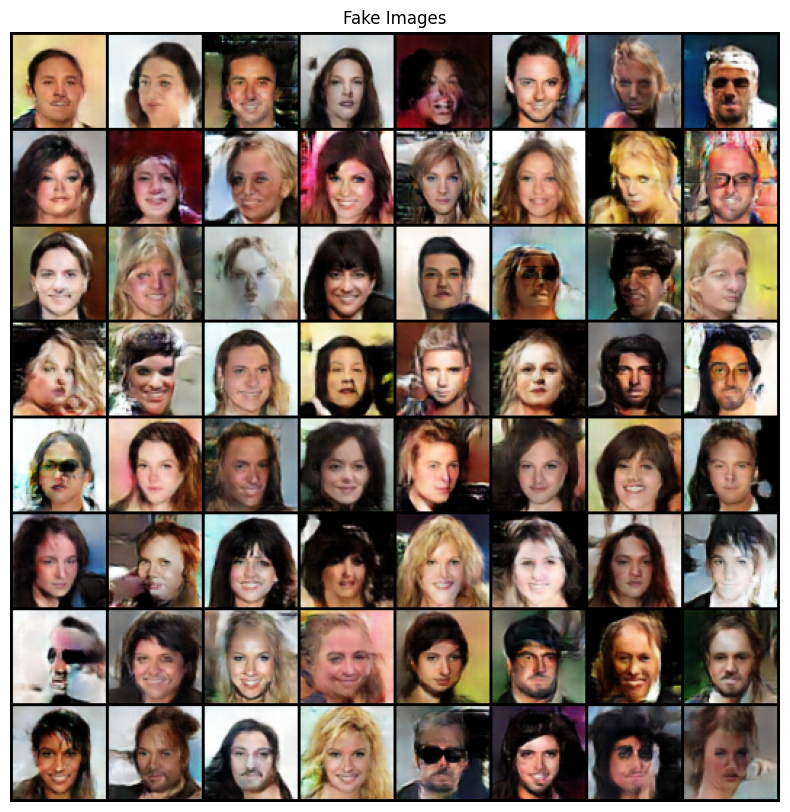

In [84]:
# Récupération d'un lot d'image du dataloader
real_batch = next(iter(dataloader))

# Affichage du résultat 
plt.figure(figsize=(25, 10))
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()